<a href="https://colab.research.google.com/github/ZEBAAFROZ/Visual_Question_Answer/blob/main/BLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00


In [7]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch

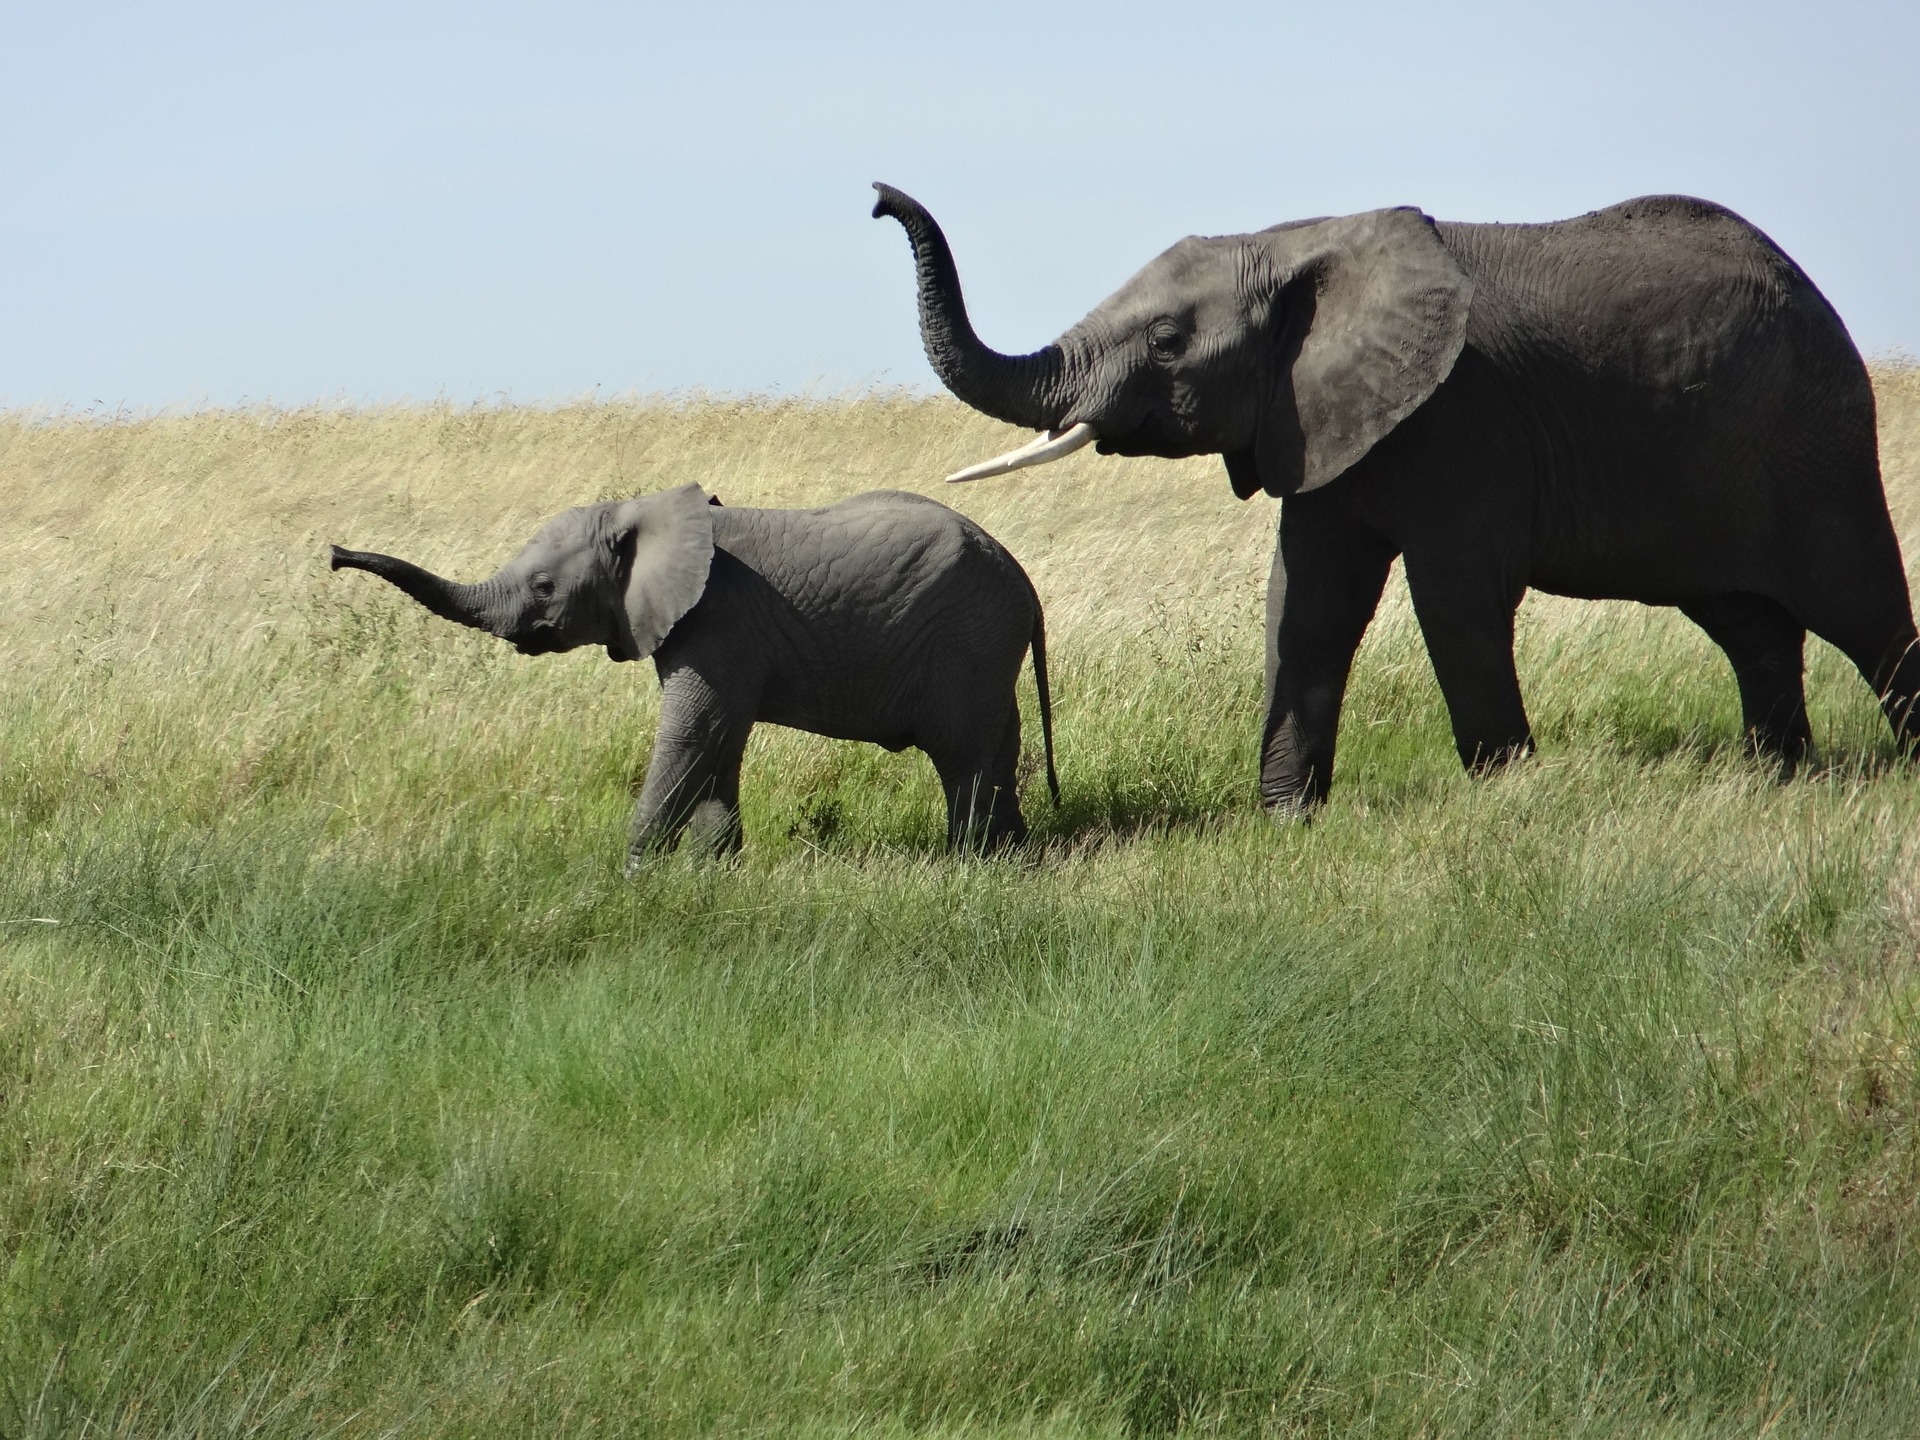

In [11]:
# load the image we will test BLIP on
img_url = 'https://i.imgur.com/Bvro0YD.png'
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [9]:
# load necessary components: the processor and the model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

In [12]:
def get_answer_blip(model, processor, image, question):
    """Answers the given question and handles all the preprocessing and postprocessing steps"""
    # preprocess the given image and question
    inputs = processor(image, question, return_tensors="pt")
    # generate the answer (get output)
    out = model.generate(**inputs)
    # post-process the output to get human friendly english text
    print(processor.decode(out[0], skip_special_tokens=True))
    return

In [14]:
# sample question 1
question = "how many elephants are in the picture?"
get_answer_blip(model, processor, image, question)

two


In [15]:
# sample question 2
question = "how will you describe the picture?"
get_answer_blip(model, processor, image, question)

elephants in field


In [16]:
# sample question 3
question = "where are they?"
get_answer_blip(model, processor, image, question)

in field


***Implementing this framework ourselves from scratch.***

In [18]:
class BLIP_VQA:
    """Custom implementation of the BLIP model. The code has been adapted from the official transformers implementation"""
    def __init__(self, vision_model, text_encoder, text_decoder, processor):
        """Initialize various objects"""
        self.vision_model = vision_model
        self.text_encoder = text_encoder
        self.text_decoder = text_decoder
        self.processor = processor

    def preprocess(self, img, ques):
        """preprocess the inputs: image, question"""
        # preprocess using the processor
        inputs = self.processor(img, ques, return_tensors='pt')
        # store the pixel values of the image, input IDs (i.e., token IDs) of the question and the attention masks separately
        pixel_values = inputs['pixel_values']
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        return pixel_values, input_ids, attention_mask

    def generate_output(self, pixel_values, input_ids, attention_mask):
        """Generates output from the preprocessed input"""
        # get the vision outputs (i.e., the image embeds)
        vision_outputs = self.vision_model(pixel_values=pixel_values)
        img_embeds = vision_outputs[0]
        # create attention mask with 1s on all the image embedding positions
        img_attention_mask = torch.ones(img_embeds.size()[: -1], dtype=torch.long)
        # encode the questions
        question_outputs = self.text_encoder(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             encoder_hidden_states=img_embeds,
                                             encoder_attention_mask=img_attention_mask,
                                             return_dict=False)
        # create attention mask with 1s on all the question token IDs positions
        question_embeds = question_outputs[0]
        question_attention_mask = torch.ones(question_embeds.size()[:-1], dtype=torch.long)
        # initialize the answers with the beginning-of-sentence IDs (bos ID)
        bos_ids = torch.full((question_embeds.size(0), 1), fill_value=30522)
        # get output from the decoder. These outputs are the generated IDs
        outputs = self.text_decoder.generate(
            input_ids=bos_ids,
            eos_token_id=102,
            pad_token_id=0,
            encoder_hidden_states=question_embeds,
            encoder_attention_mask=question_attention_mask)
        return outputs

    def postprocess(self, outputs):
        """post-process the output generated by the text-decoder"""
        return self.processor.decode(outputs[0], skip_special_tokens=True)

    def get_answer(self, image, ques):
        """Returns human friendly answer to a question"""
        # preprocess
        pixel_values, input_ids, attention_mask = self.preprocess(image, ques)
        # generate output
        outputs = self.generate_output(pixel_values, input_ids, attention_mask)
        # post-process
        answer = self.postprocess(outputs)
        return answer


In [19]:
blip_vqa = BLIP_VQA(vision_model=model.vision_model,
                    text_encoder=model.text_encoder,
                    text_decoder=model.text_decoder,
                    processor=processor)

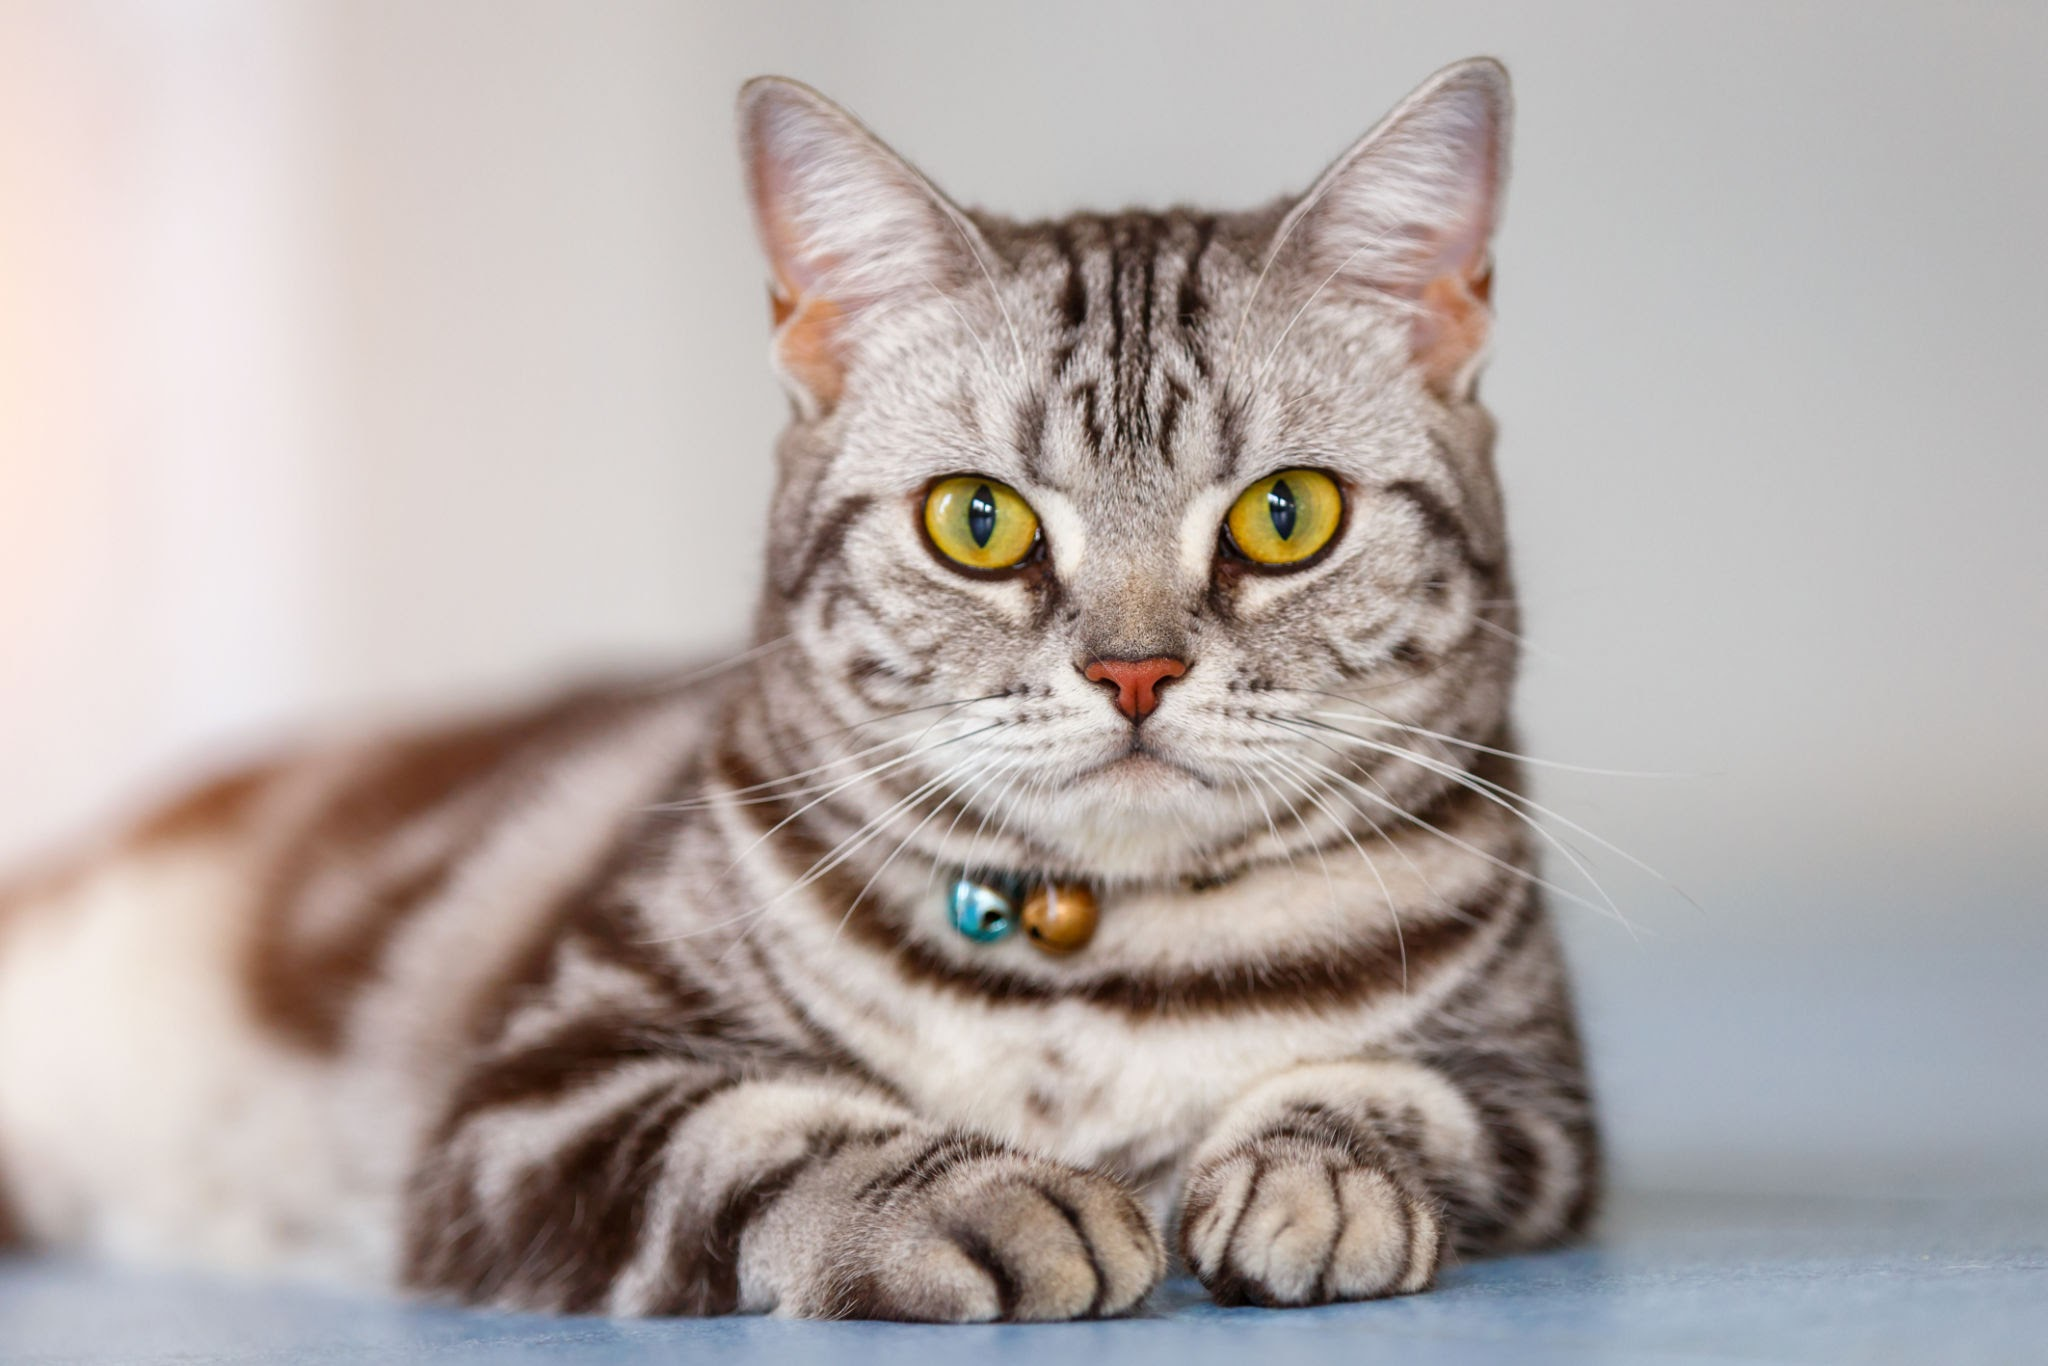

In [17]:
# load another image to test BLIP
img_url = "https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcTirTLZGJkc8CsFcR-FTUBvCuK0oW4Qlbi5zSZqfjdo8HBf8xWkrYv9M2QP0Ekpc9HGXe8l39aQZx95Od8"
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [21]:
# sample question 2
ques = "What is the major color present?"
print(blip_vqa.get_answer(image, ques))

gray


In [22]:
# sample question 1
ques = "how will you describe the picture?"
print(blip_vqa.get_answer(image, ques))

cat with striped eyes


In [23]:
# sample question 1
ques = "What is the breed of the cat in the picture?"
print(blip_vqa.get_answer(image, ques))

tabby
